# From Scratch: Implementing a Support Vector Machine for Astronomical Classification

Support Vector Machines (SVMs) are a powerful and versatile set of supervised learning models used for classification, regression, and outlier detection. The fundamental idea behind an SVM is to find a hyperplane in an N-dimensional space (where N is the number of features) that distinctly classifies the data points.

In this tutorial, we'll go through the process of building a linear SVM from the ground up using Python. We'll first implement a binary classifier and then extend it to handle multiple classes using the One-vs-Rest (OVR) strategy. We'll apply our custom SVM to a dataset of astronomical objects, aiming to classify them as galaxies, stars, or quasars.

The dataset is available [here](https://www.kaggle.com/datasets/muhakabartay/sloan-digital-sky-survey-dr16) or via the GitHub of [this tutorial]().

-----

## SVMs: The Core Idea

The goal of an SVM is to find the optimal hyperplane that separates data points of different classes. "Optimal" means the hyperplane with the largest margin, which is the maximum distance between the data points of the classes. This margin-maximization approach makes SVMs robust and effective. The data points that are closest to the hyperplane and define the margin are called **support vectors**.

### Applications of SVMs

SVMs are used across various domains, including:

  * **Image Classification**: Identifying objects in images.
  * **Text Classification**: Categorizing documents, spam filtering.
  * **Bioinformatics**: Classifying proteins and patients based on their genes.
  * **Handwriting Recognition**.

-----

## The Project: Classifying Astronomical Objects

We'll be working with a dataset for the classification of astronomical objects into three categories: **galaxies**, **stars**, and **quasars**. The prediction will be based on features derived from their light spectra and movement.

Let's get started\!

### 1\. Setup and Data Preparation

First, we import the necessary libraries and load our dataset.

In [1]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import f1_score, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

The dataset contains various identifiers and measurements. We'll drop the ID columns and separate our features (`X`) from our target variable (`y`).

In [2]:
df = pd.read_csv('astronomy.csv')
# Store the original class labels for later use
orig_class = df['class'].copy()
# Drop target and unneeded columns
df = df.drop(['class','obj_ID','run_ID','rerun_ID','cam_col','field_ID','spec_obj_ID'], axis=1)

SVMs are sensitive to the scale of the features. Therefore, it's crucial to scale our data before feeding it to the model. We'll use `StandardScaler` from scikit-learn, which standardizes features by removing the mean and scaling to unit variance.

In [3]:
scaler = StandardScaler()
scaled_data = scaler.fit_transform(df)

# Create a new DataFrame with the scaled data
scaled_df = pd.DataFrame(scaled_data, columns=df.columns)
# Add the class labels back to the scaled DataFrame
scaled_df['class'] = orig_class

#subset for faster training!
scaled_df = scaled_df[:10000] 
X = scaled_df.drop('class', axis=1)
y = scaled_df['class']

*Because the dataset contains a class imbalance (around 50% galaxies), we'll use the macro F1 score as our evaluation metric. This metric calculates the F1 score for each class independently and then averages them, treating all classes equally.*

-----

## 2\. Implementing a Binary SVM From Scratch

To start simple, we'll convert our multi-class problem into a binary one: classifying an object as a **star** or **not a star**. The SVM algorithm works best with numerical labels, so we'll encode "STAR" as `1` and the other classes ("GALAXY", "QSO") as `-1`.

The core of our SVM is the training function, which uses gradient descent to find the optimal weights (`w`) and bias (`b`) for our hyperplane. The decision rule for a linear SVM is `y * (w·x + b) >= 1`. If a data point is misclassified (or inside the margin), its parameters are updated.

In [4]:
def train_base_svm(X, y, learning_rate=0.001, n_iterations=1000):
    X = X.values
    n_samples, n_features = X.shape
    #initialize weights and  bias
    w = np.zeros(n_features)
    b = 0
    # Gradient descent loop
    for _ in range(n_iterations):
        # Iterate over each sample
        for idx, x_i in enumerate(X):
            y_i = y[idx] # Label for the sample
            # Check if the sample is misclassified or inside the margin
            if y_i * (np.dot(x_i, w) + b) < 1:
                # Update weights and bias if the condition is met
                w = w + learning_rate * (y_i * x_i)
                b = b + learning_rate * y_i
    return w, b

def predict_base_svm(X, w, b):
    X = X.values
    # Calculate the decision function
    predictions = np.dot(X, w) + b
    # Return the sign of the prediction, which corresponds to the class
    return np.sign(predictions).astype(np.int8)

# --- Binary Classification Workflow ---
binary_df = scaled_df.copy()
# Encode labels: STAR as 1, others as -1
binary_df['class'] = binary_df['class'].replace({'GALAXY':-1, 'STAR':1, 'QSO':-1})
#80/20 train-test split
binary_train, binary_test = binary_df[:8000], binary_df[8000:]
#Train the binary SVM
weights, bias = train_base_svm(binary_train.drop('class', axis=1), binary_train['class'].values)
#Make predictions on the training andf test set
predictions_train = predict_base_svm(binary_train.drop('class', axis=1), weights, bias)
predictions_test = predict_base_svm(binary_test.drop('class', axis=1), weights, bias)

print('Train data F1:', f1_score(binary_train['class'].values, predictions_train, average='macro'))
print('Test data F1:', f1_score(binary_test['class'].values, predictions_test, average='macro'))

C:\Users\maxko\AppData\Local\Temp\ipykernel_684\1148208301.py:29: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  binary_df['class'] = binary_df['class'].replace({'GALAXY':-1, 'STAR':1, 'QSO':-1})


Train data F1: 0.9796163875576239
Test data F1: 0.9739223807332413


The output shows impressive results:

train data f1: 0.9796

test data f1: 0.9739

The binary linear SVM achieves a very high F1 score on both the training and test sets, with no signs of overfitting.

-----

## 3\. Multi-Class SVM using One-vs-Rest (OVR)

Now, let's tackle the original 3-class problem. We'll use the **One-vs-Rest (OVR)** strategy. In this approach, we train one binary classifier for each class. For example, the "GALAXY" classifier is trained to distinguish galaxies (`1`) from all other classes (`-1`). We do the same for "STAR" and "QSO".

To make a prediction, a new data point is fed to all three classifiers. The classifier that returns the highest decision score (the highest value from `w·x + b`) wins, and its corresponding class is assigned to the data point.

In [6]:
def train_svm(X, y, learning_rate=0.01, n_iterations=1000, logging=True):
    unique_classes = y.unique()
    classifiers = {}
    # Train one binary SVM for each class
    for cls in unique_classes:
        if logging:
            print('training', cls, 'vs. others...')
        # Create binary labels: 1 for the current class, -1 for all others
        binary_y = np.where(y == cls, 1, -1)
        # Train the base binary SVM
        weights, bias = train_base_svm(X, binary_y, learning_rate, n_iterations)
        classifiers[cls] = (weights, bias)

    return classifiers

def predict_svm(X, ovr_classifiers):
    X_values = X.values
    num_samples = X_values.shape[0]
    class_labels = list(ovr_classifiers.keys())
    num_classifiers = len(class_labels)
    # Store the decision function scores for each classifier
    scores = np.zeros((num_samples, num_classifiers))

    # Get scores from each binary classifier
    for i, cls in enumerate(class_labels):
        weights, bias = ovr_classifiers[cls]
        # Get the raw scores from the decision function
        scores[:, i] = np.dot(X_values, weights) + bias

    # The class with the highest score is the prediction
    predicted_indices = np.argmax(scores, axis=1)
    predicted_classes = np.array([class_labels[i] for i in predicted_indices])
    
    return predicted_classes


# --- Multi-Class Classification Workflow ---
#80/20 train-test split
multi_train, multi_test = scaled_df[:8000], scaled_df[8000:]
y_test_multi = multi_test['class']

# Train the OVR SVM
classifiers = train_svm(multi_train.drop('class', axis=1), multi_train['class'])

# Make predictions on the train and test sets
train_predictions = predict_svm(multi_train.drop('class', axis=1), classifiers)
test_predictions = predict_svm(multi_test.drop('class', axis=1), classifiers)

print('Train f1:', f1_score(multi_train['class'].values, train_predictions, average='macro'))
print('Test f1:', f1_score(multi_test['class'].values, test_predictions, average='macro'))

training GALAXY vs. others...
training QSO vs. others...
training STAR vs. others...
Train f1: 0.9016010848224502
Test f1: 0.8866385088489878


The performance for the multi-class task remains strong:

Train f1: 0.9016

Test f1: 0.8866

The F1 score is slightly lower than the binary case, as expected for a more complex problem, but it's still an excellent result for a linear classifier built from scratch.

### 4\. Analyzing the Results

A **confusion matrix** helps us visualize where the model is making mistakes.

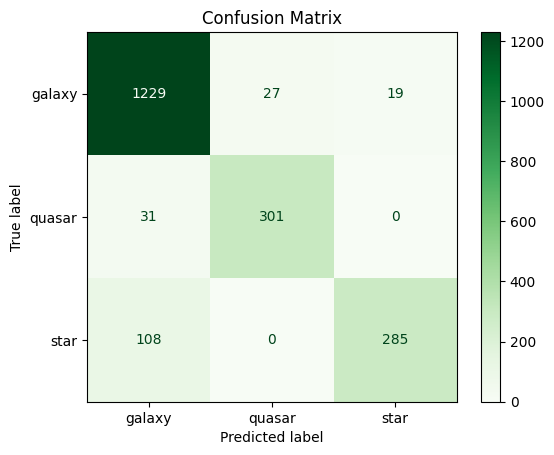

In [7]:
cm = confusion_matrix(y_test_multi, test_predictions)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['galaxy', 'quasar', 'star'])
disp.plot(cmap=plt.cm.Greens)
plt.title('Confusion Matrix')
plt.show()

From the matrix, we can see:

  * All classes are identified with high accuracy.
  * There's some confusion between galaxies and quasars.
  * Interestingly, there are no confusions between quasars and stars. This is likely because stars have narrow, specific light spectra, while quasars have very broad spectra, making them easier to distinguish from each other.

-----

## Conclusion

In this tutorial, we successfully built and understood the inner workings of a linear Support Vector Machine. We started with a binary classifier and extended it to a multi-class scenario using the One-vs-Rest approach. Our from-scratch implementation performed remarkably well on a real-world astronomical dataset.

Given that we only used a linear kernel, the performance is great. The remaining misclassifications could likely be addressed by exploring non-linear kernels (like RBF or Polynomial), which allow the SVM to find more complex, non-linear decision boundaries.